# Nodule Segmentation: Model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration" data-toc-modified-id="Configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Find-mean-of-images" data-toc-modified-id="Find-mean-of-images-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Find mean of images</a></span></li><li><span><a href="#Find-variance-of-images" data-toc-modified-id="Find-variance-of-images-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find variance of images</a></span></li></ul></li><li><span><a href="#Data-Iterator" data-toc-modified-id="Data-Iterator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Iterator</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation Metric</a></span></li><li><span><a href="#Model-Architecture" data-toc-modified-id="Model-Architecture-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Architecture</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimizer</a></span><ul class="toc-item"><li><span><a href="#Find--learning-rate" data-toc-modified-id="Find--learning-rate-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Find  learning rate</a></span></li><li><span><a href="#Optimizer-Parameters" data-toc-modified-id="Optimizer-Parameters-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Optimizer Parameters</a></span></li></ul></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Evaluate-Model" data-toc-modified-id="Evaluate-Model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluate Model</a></span></li></ul></div>

In [31]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0,"./src")

In [3]:
import mynnet7 as nn
import pickle
import mxnet as mx
from imports import *

## Configuration

In [4]:
interm_dir4='/home/mas/x110/Datasets/Dataset5/' 
s = "2018_11_06"
train_data_path=interm_dir4+'processed/train'+s+'.rec'
train_idx_path=interm_dir4+'processed/train'+s+'.idx'
valid_data_path=interm_dir4+'processed/valid'+s+'.rec'
valid_idx_path=interm_dir4+'processed/valid'+s+'.idx'
test_data_path=interm_dir4+'processed/test'+s+'.rec'
test_idx_path=interm_dir4+'processed/test'+s+'.idx'

In [5]:
find_stats = False#True
bs = 34
load_model = True
model_path = "/home/mas/x110/model/nov8"
model_epoch=40
prefix = "/home/mas/x110/model/nov10"

In [6]:
epochs = 50

## Preprocessing

### Find mean of images

In [7]:
if find_stats:
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image=1)
    train_iter.reset()
    x_mean = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  batch.data[0][0][0].asnumpy()
        x_mean+=X
    x_mean=np.mean(x_mean/i)
    # Saving the objects:
    with open(interm_dir4+'processed/x_mean.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_mean], f)

else:
    with open(interm_dir4+'processed/x_mean.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_mean = pickle.load(f)
x_mean#x_mean=0.2826227159416579

[0.2826227159416579]

In [8]:
x_mean=0.28

### Find variance of images

In [9]:
if find_stats: 
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image = 1)
    train_iter.reset()
    x_var = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  (batch.data[0][0][0].asnumpy()-x_mean)**2
        x_var+=X
    #x_var=x_var/(i-1)
    #x_var#x_mean=.2815
    N = i*32*32*32
    x_var = np.sum(x_var)/(N-1)
    x_var#x_var = .07877
    x_std = np.sqrt(x_var)#x_std=.2807
    with open(interm_dir4+'processed/x_std.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_std], f)
else:
    with open(interm_dir4+'processed/x_std.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_std = pickle.load(f)
x_std#x_std=0.2817920662435274

[0.2817920662435274]

In [10]:
x_std = 0.28

## Data Iterator

In [11]:
BATCH_SIZE=bs
train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,random_flip=True,do_augment=False,mean_image=x_mean,std_image = x_std)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'softmax_label': (34, 32768), 'data': (34, 1, 32, 32, 32)}


In [12]:
BATCH_SIZE=bs
valid_iter=nn.FileIter(valid_data_path,valid_idx_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean,std_image = x_std)

In [13]:
train_iter.reset()
valid_iter.reset()

## Evaluation Metric

In [14]:
def dice_coef2(label, y):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    intersection = mx.nd.sum(label*y)
    return ((2. * intersection + smooth) / (mx.nd.sum(label) +mx.nd.sum(mx.nd.abs(y)) + smooth))


In [15]:
# ===============Evaluation metric(s)================= 
metric = mx.metric.CustomMetric(feval=nn.dice_coef2)

## Model Architecture

In [16]:
load_model

True

In [17]:
if load_model:
    network, arg_params, aux_params = mx.model.load_checkpoint(model_path , model_epoch)

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)


    exe.copy_params_from(arg_params, aux_params)
    
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
else:

    network = nn.get_net_319()
    init = mx.init.Normal(0.01) #note biases and gamma/beta are not affected

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(), **input_shapes)
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
    for name, arr in arg_arrays.items():
        if name not in input_shapes:
            init(name, arr)


## Optimizer

### Find  learning rate

In [22]:
nb=train_iter.num_data//train_iter.batch_size

In [23]:
train_iter.num_data

3154

In [24]:
sched=nn.lr_find(1e-4,nb,end_lr=1)

In [25]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.01,
    momentum=0.9,
    wd=0.00001,
    lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)

In [26]:
for epoch in range(0,1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    
    sched.reset()
        
    sched.on_train_begin()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
        e=metric.get()
        err_train=-e[1].asnumpy()[0]
        sched.on_batch_end(err_train)
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 139.71921133995056 Epoch: 0 trainloss: -0.77615017 validloss: -0.6690476


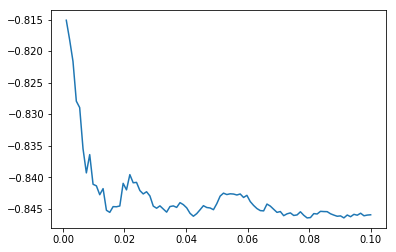

In [27]:
plt.plot(sched.lrs, sched.losses)

### Optimizer Parameters

In [27]:
# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=.005,momentum=0.99,wd=0.000001)

In [28]:
updater = mx.optimizer.get_updater(opt)

In [29]:
updater.optimizer.lr_scheduler=None

## Train Model

In [30]:
Es_train=[]
for epoch in range(0,epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 10== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 129.6122121810913 Epoch: 0 trainloss: -0.7763073 validloss: -0.6888232
time: 129.92504000663757 Epoch: 1 trainloss: -0.78183365 validloss: -0.66417503
time: 130.39435839653015 Epoch: 2 trainloss: -0.7794458 validloss: -0.6870097
time: 130.6569046974182 Epoch: 3 trainloss: -0.7853149 validloss: -0.6795051
time: 130.52715492248535 Epoch: 4 trainloss: -0.7822655 validloss: -0.69095606
time: 130.6436746120453 Epoch: 5 trainloss: -0.78529745 validloss: -0.67396736
time: 130.52947115898132 Epoch: 6 trainloss: -0.7834672 validloss: -0.68566775
time: 130.45284724235535 Epoch: 7 trainloss: -0.7841172 validloss: -0.6832763
time: 130.69531273841858 Epoch: 8 trainloss: -0.77846575 validloss: -0.6486394
time: 130.56378507614136 Epoch: 9 trainloss: -0.7806889 validloss: -0.6660738
time: 130.76282167434692 Epoch: 10 trainloss: -0.78919595 validloss: -0.6770344
time: 130.6620786190033 Epoch: 11 trainloss: -0.78717524 validloss: -0.68323237
time: 130.5608594417572 Epoch: 12 trainloss: -0.7893604 

KeyboardInterrupt: 

In [ ]:
np.mean(Es_train2,axis=1)

In [ ]:
Es_train = np.array(Es_train)

In [ ]:
Es_train2 = Es_train.reshape((-1,2))

In [ ]:
np.mean(Es_train2,axis=1)

In [ ]:
plt.plot(Es_train,'.-')

## Evaluate Model

In [36]:
BATCH_SIZE=1
train_iter=nn.FileIter(test_data_path,test_idx_path,batch_size=BATCH_SIZE,do_augment=False,do_shuffle=False,mean_image=x_mean,std_image = x_std)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'softmax_label': (1, 32768), 'data': (1, 1, 32, 32, 32)}


In [32]:
BATCH_SIZE=1
test_iter=nn.FileIter(valid_data_path,valid_idx_path,batch_size=BATCH_SIZE,do_shuffle=False,mean_image=x_mean,std_image = x_std)

In [37]:
def get_sample_at(valid_iter,n):
    valid_iter.ind2=[n]
    return valid_iter.next()

index = 873


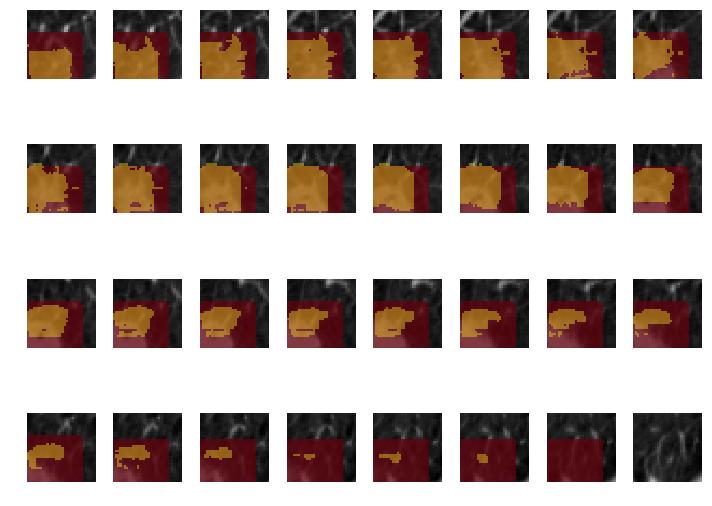

In [39]:
K = train_iter.num_data
n = random.randint(0,K)
print('index = '+ str(n))
batch = get_sample_at(train_iter,n)


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X*x_std+x_mean
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], 'gray',vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.7, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none',  alpha=0.4, vmin=0, vmax=1)


      
plt.tight_layout()

Sample of the results. the yellow region is the label. the red region is the model annotation. 